In [1]:
import re
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.metrics import f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk import *
import spacy
nlp = spacy.load("en")

stop_words=stopwords.words('english')

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

import gc
gc.collect()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
go = pd.read_csv('game_overview.csv')

In [3]:
train.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [7]:
sent_analyzer=SentimentIntensityAnalyzer()
def sentiment(df):
    df["sentiment"] = df['user_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
    df = pd.concat([df.drop(['sentiment'], axis=1),\
                       df['sentiment'].apply(pd.Series)], \
                      axis=1)
    df.drop(["neg","neu","pos"],axis=1,inplace=True)

    df.rename(columns ={"compound":"sent_score_vader"},inplace=True)
    df['sent_score_textblob'] = df['user_review'].apply(lambda x: list(TextBlob(x).sentiment)[0])
    return df

train=sentiment(train)
test=sentiment(test)

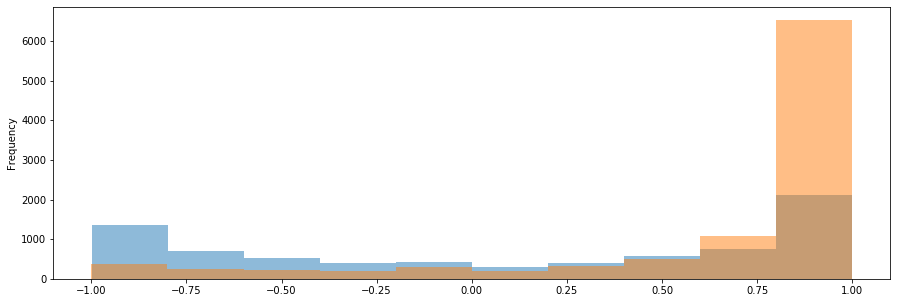

In [9]:
plt.figure(figsize=(15,5))
train.groupby(['user_suggestion'])['sent_score_vader'].plot(kind='hist',alpha=0.5)
plt.show()

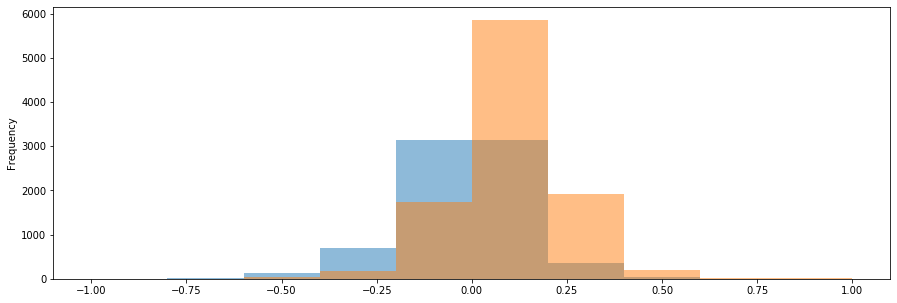

In [10]:
plt.figure(figsize=(15,5))
train.groupby(['user_suggestion'])['sent_score_textblob'].plot(kind='hist',alpha=0.5)
plt.show()

In [11]:
go.head()

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...
3,Fractured Space,Edge Case Games Ltd.,Edge Case Games Ltd.,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",Take the helm of a gigantic capital ship and g...
4,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...


In [12]:
go_tags=go.copy()
def clean_tag(tag):
    tag = re.sub(r"[\'\[\]]","",tag)
    tag = re.sub(r'\s','',tag)
    tag = re.sub(r'\"','',tag)
    return tag
go_tags['tags']=go_tags['tags'].apply(lambda x: clean_tag(x))

temp=go_tags['tags'].str.split(',')

go_tags=go_tags.reindex(go_tags.index.repeat(temp.apply(len)))
go_tags['tags_new'] = np.hstack(temp)
go_tags=go_tags[['title','tags_new']]
go_tags=pd.crosstab(go_tags.title,go_tags.tags_new)
go_tags.head()

tags_new,2D,2DFighter,3DVision,4PlayerLocal,Action,Action-Adventure,ActionRPG,Adventure,America,Anime,Arcade,Atmospheric,BaseBuilding,BasedOnANovel,Basketball,BattleRoyale,Beatemup,Blood,BoardGame,Building,BulletHell,Capitalism,CardGame,Cartoon,Cartoony,Casual,CharacterCustomization,CityBuilder,Class-Based,Classic,Clicker,Co-op,Comedy,ComicBook,Competitive,Controller,Crafting,CultClassic,Cute,Dark,DarkFantasy,DarkHumor,DatingSim,Destruction,Difficult,Dragons,Driving,DungeonCrawler,Dungeons&Dragons,EarlyAccess,Education,Exploration,FPS,FamilyFriendly,Fantasy,Fast-Paced,FemaleProtagonist,Fighting,First-Person,Fishing,Flight,FreetoPlay,Funny,Futuristic,Gambling,Gore,GreatSoundtrack,GunCustomization,HackandSlash,Historical,Horror,Hunting,Illuminati,Indie,InventoryManagement,Isometric,JRPG,LocalCo-Op,LocalMultiplayer,Loot,MMORPG,MOBA,Magic,Management,MassivelyMultiplayer,Masterpiece,Mature,Medieval,Memes,Military,Mod,Moddable,Multiplayer,Mythology,NSFW,Naval,Nudity,OnlineCo-Op,OpenWorld,PermaDeath,PixelGraphics,Platformer,Post-apocalyptic,PsychologicalHorror,Puzzle,PvE,PvP,RPG,RTS,Racing,Real-Time,RealTimeTactics,Realistic,Relaxing,ReplayValue,ResourceManagement,Retro,Robots,Rogue-like,Romance,Sandbox,Sci-fi,SexualContent,Shooter,SideScroller,Simulation,Singleplayer,Space,SpaceSim,Sports,Stealth,StoryRich,Strategy,StrategyRPG,Superhero,Survival,SurvivalHorror,Tactical,TacticalRPG,Tanks,Team-Based,Third-PersonShooter,ThirdPerson,Top-Down,TowerDefense,TrackIR,Trading,TradingCardGame,Turn-Based,Turn-BasedStrategy,Turn-BasedTactics,VR,Violent,VisualNovel,Voxel,WalkingSimulator,War,WorldWarI,WorldWarII,Zombies,e-sports
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AdventureQuest 3D,0,0,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aura Kingdom,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Black Squad,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Bless Online,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Bloons TD Battles,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
def user_review_stat(df):
    
    df['user_review_len'] = df['user_review'].apply(len)
    
    def word_count(x):
        user_review = [t for t in x.split()]
        t = [a for a in user_review if a.isalpha()]
        return len(t)
    df['word_count'] = df['user_review'].apply(lambda x: word_count(x))
    
    df['stop_word_count'] = df['user_review'].apply(lambda x: len([t for t in str(x).split() if t.lower() not in stop_words]))
    df['punct_count'] = df['user_review'].apply(lambda x: len([t for t in str(x) if t in string.punctuation]))
    df['caps_count'] = df['user_review'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    
    df['caps_ratio'] = df['caps_count'] / df['user_review_len']
    
    df['stopByWord']=df['stop_word_count']/(df['word_count']+1)
    df['avgLenWord']=df['user_review_len']/(df['word_count']+1)
    return df
                                        
                                             
train = user_review_stat(train)
test = user_review_stat(test)

In [14]:
train = pd.merge(train,go_tags,on='title',how='left')
test = pd.merge(test,go_tags,on='title',how='left')

In [15]:
train['type']='train'
test['type']='test'
data=pd.concat([train,test],ignore_index=True)
data = pd.merge(data,go[['title','publisher']],on='title',how='left')
data = pd.get_dummies(data,columns=['publisher'])
train=data[data['type']=='train']
test=data[data['type']=='test']
train.drop(['type'],axis=1,inplace=True)
test.drop(['type'],axis=1,inplace=True)
del(data)

In [16]:
#USing Text Statistics and Sentiment Analysis for classification
clf=lgb.LGBMClassifier(n_estimators=50,\
                      max_depth=5,\
                      num_leaves=70)
cols=['review_id','title','year','user_review','user_suggestion']
X = train[[col for col in train.columns if col not in cols]]
y=train.user_suggestion
xtrain, xval, ytrain, yval = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

clf.fit(X,y)
score = f1_score(yval,clf.predict(xval))
print(round(score,3),end=",")

predTextStats = clf.predict_proba(test[X.columns])[:,1]

0.852,

In [17]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.wordnet.ADV
    else:
        return wordnet.wordnet.NOUN

def text_clean(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('[~!@#$\'%&*()-?=]+',' ',text)
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    
    return text

def lemmatize(text):
    pos_tags = pos_tag(nltk.word_tokenize(text))
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t)>2]
    text = [t for t in text if t not in stop_words]
    text= " ".join(text)
    return text

train['text_clean'] = train['user_review'].apply(lambda x: text_clean(x))
test['text_clean'] = test['user_review'].apply(lambda x: text_clean(x))


train['text_clean'] = train['text_clean'].apply(lambda x: lemmatize(x))
test['text_clean'] = test['text_clean'].apply(lambda x: lemmatize(x))

In [18]:
# Logistic Regression using TF-IDF as input vector

X = list(train.text_clean)
test_=list(test.text_clean)
y=train.user_suggestion
xtrain, xval, ytrain, yval = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)


tfv = TfidfVectorizer(min_df=3,  max_features=5000, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1)


ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',max_features=5000,
            ngram_range=(1, 2))


#train and valation for TF-IDF
tfv.fit(X+test_)
xtrain_tfv =  tfv.transform(xtrain) 
xval_tfv = tfv.transform(xval)
X =tfv.transform(X)
test_tfv=tfv.transform(test.text_clean)



clf = LogisticRegression(C=1)
clf.fit(X,y)
score = f1_score(yval,clf.predict(xval_tfv))
print(round(score,3),end=",")

predTfidf = clf.predict_proba(test_tfv)[:,1]

0.906,

In [21]:
# Logistic Regression using CountVectorizer as input vector
X = list(train.text_clean)
test_=list(test.text_clean)
y=train.user_suggestion
xtrain, xval, ytrain, yval = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)


#train and valation for Count Vectorizer
ctv.fit(X+test_)
xtrain_ctv =  ctv.transform(xtrain) 
xval_ctv = ctv.transform(xval)
test_ctv=ctv.transform(test.text_clean)
X =ctv.transform(X)


clf = LogisticRegression(C=1)
clf.fit(X,y)
score = f1_score(yval,clf.predict(xval_ctv))
print(round(score,3),end=",")

predCountVec = clf.predict_proba(test_ctv)[:,1]

0.956,

In [ ]:
embeddings_index = {}
f = open(os.path.expanduser('~/Desktop/glove.6B/glove.6B.50D.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [22]:
# using word embeddings as features 
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(50)
    return v / np.sqrt((v ** 2).sum())

train['embed'] = train['text_clean'].apply(lambda x: sent2vec(x))
train = pd.concat([train,train.embed.apply(pd.Series)],axis=1)

test['embed'] = test['text_clean'].apply(lambda x: sent2vec(x))
test = pd.concat([test,test.embed.apply(pd.Series)],axis=1)

train.drop(['embed'],axis=1,inplace=True)
test.drop(['embed'],axis=1,inplace=True)

In [23]:
cols = ['review_id',           'title',            'year',
           'user_review', 'user_suggestion',      'text_clean','embed','user_suggestion']

X = train[[col for col in train.columns if col not in cols]]
y=train.user_suggestion
test_=test[X.columns]
xtrain, xval, ytrain, yval = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

#test_ = test[X.columns]
clf = lgb.LGBMClassifier()
clf.fit(X,y)
score = f1_score(yval,clf.predict(xval))
print(round(score,3),end=",")

predEmbed = clf.predict_proba(test_)[:,1]

0.871,

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.callbacks import *

Using TensorFlow backend.


In [50]:
embeddings_index = {}
f = open(os.path.expanduser('~/Desktop/glove.6B/glove.6B.50D.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [51]:
X = train.text_clean
y=train.user_suggestion
xtrain, xval, ytrain, yval = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)


tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(train.text_clean)+list(test.text_clean))

x_tr_seq  = tokenizer.texts_to_sequences(xtrain) 
x_val_seq = tokenizer.texts_to_sequences(xval)
test_seq = tokenizer.texts_to_sequences(test.text_clean)
x_all_seq  = tokenizer.texts_to_sequences(X)

x_tr_seq  = pad_sequences(x_tr_seq, maxlen=300)
x_val_seq = pad_sequences(x_val_seq, maxlen=300)
test_seq = pad_sequences(test_seq,maxlen=300)
x_all_seq  = pad_sequences(x_all_seq,maxlen=300)

size_of_vocabulary=len(tokenizer.word_index) + 1
print(size_of_vocabulary)


embedding_matrix = np.zeros((size_of_vocabulary, 50))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

59539


In [52]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [54]:
model=Sequential()

#model.add(Embedding(size_of_vocabulary,50,weights=[embedding_matrix],input_length=300,trainable=False)) # use glove embedding
model.add(Embedding(size_of_vocabulary,50,input_length=300))   # use of training data

model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(20,activation='relu')) 
model.add(Dropout(0.05))
model.add(Dense(1,activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[f1_m]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=6)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

history = model.fit(np.array(x_tr_seq),np.array(ytrain),\
                    batch_size=100,epochs=10,
                    validation_data=(np.array(x_val_seq),np.array(yval)),\
                    verbose=1,callbacks=[es,mc])

predKerasEmbed = model.predict(test_seq)

Train on 15744 samples, validate on 1750 samples
Epoch 1/10
15744/15744 [==============================] - 45s 3ms/step - loss: 0.5764 - f1_m: 0.7536 - val_loss: 0.5325 - val_f1_m: 0.7520
Epoch 2/10
15744/15744 [==============================] - 46s 3ms/step - loss: 0.4954 - f1_m: 0.7958 - val_loss: 0.4997 - val_f1_m: 0.7997
Epoch 3/10
15744/15744 [==============================] - 46s 3ms/step - loss: 0.4626 - f1_m: 0.8100 - val_loss: 0.4727 - val_f1_m: 0.8049
Epoch 4/10
15744/15744 [==============================] - 46s 3ms/step - loss: 0.4273 - f1_m: 0.8314 - val_loss: 0.4525 - val_f1_m: 0.8224
Epoch 5/10
15744/15744 [==============================] - 40s 3ms/step - loss: 0.4035 - f1_m: 0.8406 - val_loss: 0.4446 - val_f1_m: 0.8251
Epoch 6/10
15744/15744 [==============================] - 69s 4ms/step - loss: 0.3785 - f1_m: 0.8538 - val_loss: 0.4302 - val_f1_m: 0.8350
Epoch 7/10
15744/15744 [==============================] - 46s 3ms/step - loss: 0.3531 - f1_m: 0.8657 - val_loss: 0.42

In [29]:
#ensemble
temp=test.copy()
temp['predTextStats'] = predTextStats
temp['predTfidf'] = predTfidf
temp['predCountVec'] = predCountVec
temp['predEmbed'] = predEmbed
temp['predKerasEmbed']=predKerasEmbed
temp.index=temp.review_id
temp['user_suggestion']=(temp['predTextStats']+temp['predTfidf']+temp['predCountVec']+temp['predEmbed']+temp['predKerasEmbed'])/5
# temp=temp[['user_suggestion']]
# temp['user_suggestion']=np.where(temp['user_suggestion']>=0.5,1,0)
# temp.to_csv('try6.csv')
# temp.head()

In [47]:
temp2=temp[['predTextStats','predTfidf','predCountVec','predEmbed','predKerasEmbed']]
temp2.head()

,predTextStats,predTfidf,predCountVec,predEmbed,predKerasEmbed
review_id,,,,,
1603,0.841428,0.392571,9.350903e-02,0.774952,0.001002
1604,0.238391,0.016820,9.615599e-07,0.185999,0.000045
1605,0.666686,0.085117,6.747958e-09,0.707036,0.001010
1606,0.345172,0.205423,1.491255e-01,0.367575,0.001144
1607,0.721096,0.818344,1.000000e+00,0.779621,0.996453


In [48]:
temp2['user_suggestion']=(temp2['predTextStats']+temp2['predTfidf']+temp2['predCountVec']+temp2['predEmbed'])/4
temp2=temp2[['user_suggestion']]
temp2['user_suggestion']=np.where(temp2['user_suggestion']>=0.5,1,0)
temp2.to_csv('try8.csv')
temp2.head()

,user_suggestion
review_id,
1603,0
1604,0
1605,0
1606,0
1607,1
